# Analysis notebook

## Motivations and goals
The goal of this project is to predict price of selling a house depending on different features.

We selected the following 3 questions:

1. Is having a basement having an impact on the price of a house?
2. Are the new build cheaper than older houses?
3. What are the most important features for our model?

Note: the EDA RMarkdown file goes into more details than what we have in the below.

In [74]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as stats
import seaborn as sns
from sklearn.impute import KNNImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor, plot_importance, DMatrix

import shap


## Step 0: Import the files

We import the files train.csv and test.csv, put them together to make sure they have the same levels. We will pre-process the data on the full dataset to simplify this analysis.

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test['SalePrice'] = np.nan

df = pd.concat(
    [
        train,
        test 
    ],
    axis = 0,
    ignore_index= True
)
print(train.shape)
print(test.shape)
print(df.shape)

(1460, 81)
(1459, 81)
(2919, 81)


In [3]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

We keep the Id column for now, but it will be removed later on.

## Step 1 - Exploring the output column

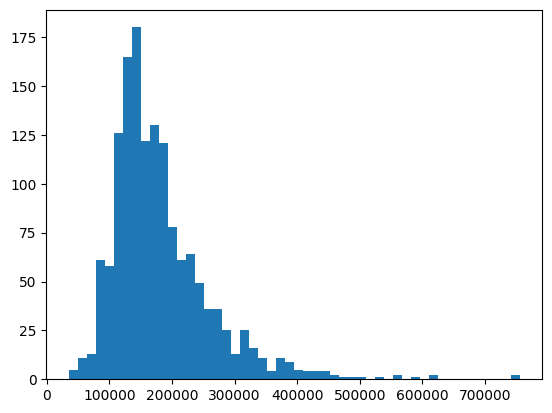

In [4]:
# histogram of SalePrice
plt.hist(
    df['SalePrice'],
    bins = 50
);

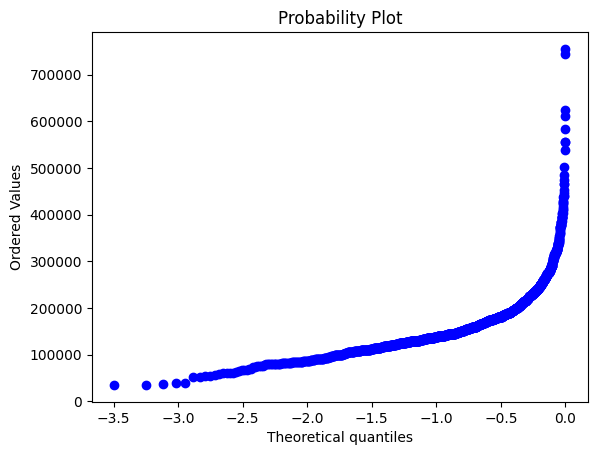

In [5]:
# qq plot
stats.probplot(
    df['SalePrice'],
    dist="norm",
    plot=pylab
)
pylab.show()

We see that the SalePrice column has a right tail. Let's log the predictions to have a normally distributed target.


In [6]:
# let's log transform the SalePrice column
df['SalePrice'] = np.log(df['SalePrice'])

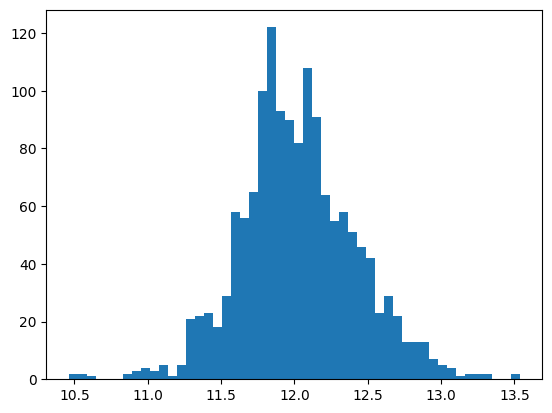

In [7]:
# histogram of SalePrice
plt.hist(
    df['SalePrice'],
    bins = 50
);

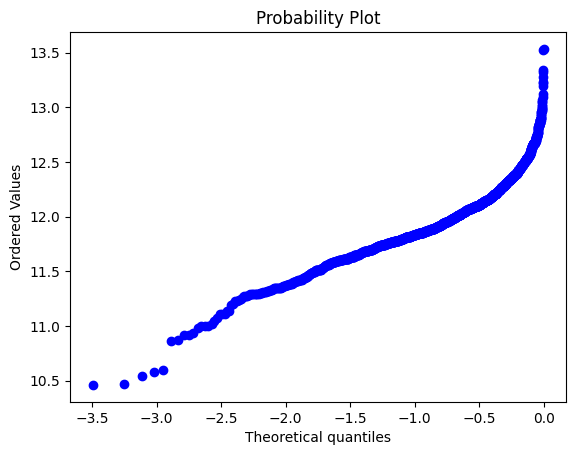

In [8]:
# qq plot
stats.probplot(
    df['SalePrice'],
    dist="norm",
    plot=pylab
)
pylab.show()

We see that 5 sales have very low SalePrices and 2 very high ones.

After short investigation, we can see that the 5 houses with low SalePrice are very old houses (built before 1950) of below average general condition and usually with an abnormal sale condition.

As for the 2 rows with very high SalePrice, they were built around 1994-6, with overall excellent condition for each check done (Garages, rooms, Kitchen, etc). One even has a pool.

We do not consider these 7 profiles as outliers, and will keep them in the analysis.

## Step 2 - Missing values

Let's first look at the columns with missing values:

In [9]:
# check missing values
missing_vals = df.isna().sum()[df.isna().sum()>0]

In [10]:
print(
    f"""
    {len(missing_vals)} predictors have missing values, and SalePrice is missing {missing_vals["SalePrice"]} times, as expected.
    """
)


    35 predictors have missing values, and SalePrice is missing 1459 times, as expected.
    


Let's look at each of these predictors with missing variable, group by group, to try to understand the best way to fill them.

### 2.1 Pool variables

In [11]:
print(
    f"""PoolQC is pool quality, where NA means in theory "no pool". It is an ordered factor with {np.round(missing_vals['PoolQC']/df.shape[0]*100,4)}% of NAs.  It is an ordered variable.
""")

PoolQC is pool quality, where NA means in theory "no pool". It is an ordered factor with 99.6574% of NAs.  It is an ordered variable.



In [12]:
df[df['PoolQC'].isna()]['PoolArea'].value_counts()

0      2906
368       1
444       1
561       1
Name: PoolArea, dtype: int64

There is another variable called PoolArea, for the area of the pool. When we look at the area if there is a pool or not, we see that the area is most of the time 0 if there is no pool.

We will add "No" as a level, and replace all NAs that have 0 as area by "No". the NAs with PoolArea>0 will be filled based on the Overall quality of the house: 

- if OverallQual is <= 2, returns "Po"
- else, if OverallQual is <= 4, returns "Fa"
- else, if OverallQual is <= 6, returns "TA"
- else, if OverallQual is <= 8, returns "Gd"
- else, returns "Ex"

In [13]:
df['PoolQC'] = df['PoolQC'].map(str)
df['overall_fac'] = np.select(
    [
        df['OverallQual'] <= 2,
        df['OverallQual'] <= 4,
        df['OverallQual'] <= 6,
        df['OverallQual'] <= 8
    ],
    [
        'Po','Fa','TA','Gd'
    ],
    'Ex'
)
df['PoolQC'] = np.select(
    [
        (df['PoolQC'].isna()) & ( df['PoolArea'] > 0 ),
        (~ df['PoolQC'].isna()) & ( df['PoolArea'] > 0 ),
    ],
    [ 
        df['overall_fac'],
        df['PoolQC']
    ],
    "No"
)

### 2.2 MiscFeature variable

In [14]:
print(f"If we look at the variable MiscFeature, we see that {np.round(missing_vals['MiscFeature']/df.shape[0]*100,4)}% of the values are missing. It is an unordered factor.")

If we look at the variable MiscFeature, we see that 96.4029% of the values are missing. It is an unordered factor.


When looking at the boxplots we see that when there are values, the impact on the sold price is quite significant.


<AxesSubplot: xlabel='MiscFeature', ylabel='SalePrice'>

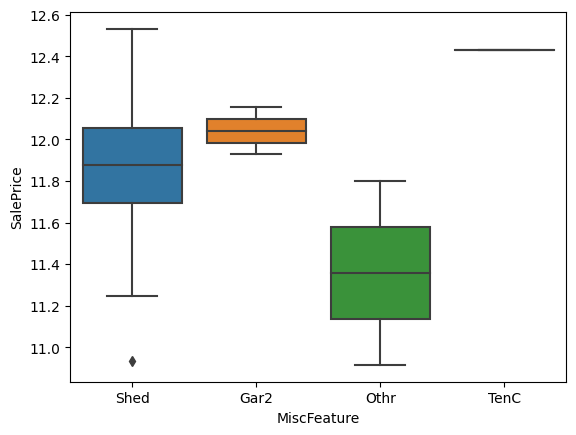

In [15]:
sns.boxplot(
    x = 'MiscFeature',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We are replacing the missing Misc feature by "No"

In [16]:
df['MiscFeature'] = df['MiscFeature'].fillna('No')

<AxesSubplot: xlabel='MiscFeature', ylabel='SalePrice'>

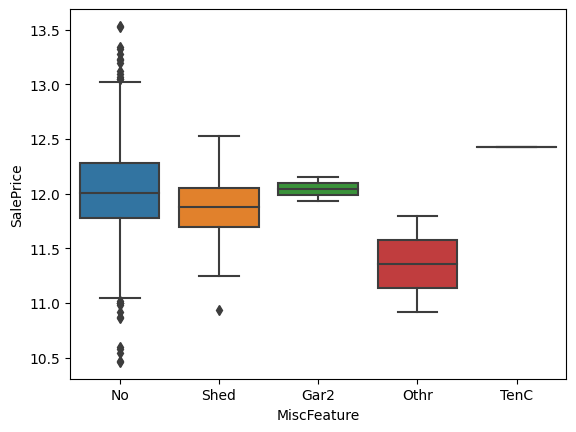

In [17]:
sns.boxplot(
    x = 'MiscFeature',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 2.3 Alley variable

In [18]:
print(f"The Alley contains the type of alley to the house, where a missing value means that there is not any alley. {np.round(missing_vals['Alley']/df.shape[0]*100,4)}% of the values are missing. It is an unordered factor.")

The Alley contains the type of alley to the house, where a missing value means that there is not any alley. 93.2169% of the values are missing. It is an unordered factor.


<AxesSubplot: xlabel='Alley', ylabel='SalePrice'>

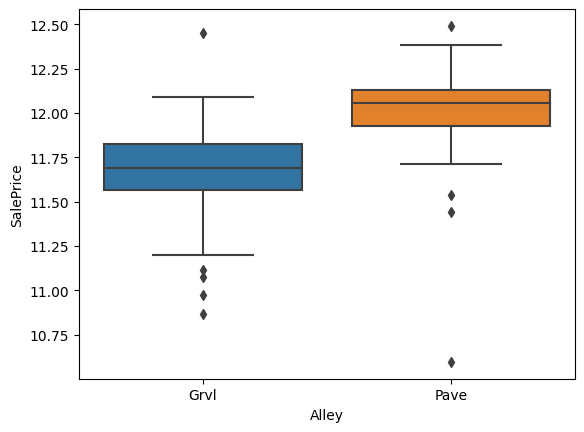

In [19]:
sns.boxplot(
    x = 'Alley',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We replace the missing values by "No".

In [20]:
df['Alley'] = df['Alley'].fillna('No')

<AxesSubplot: xlabel='Alley', ylabel='SalePrice'>

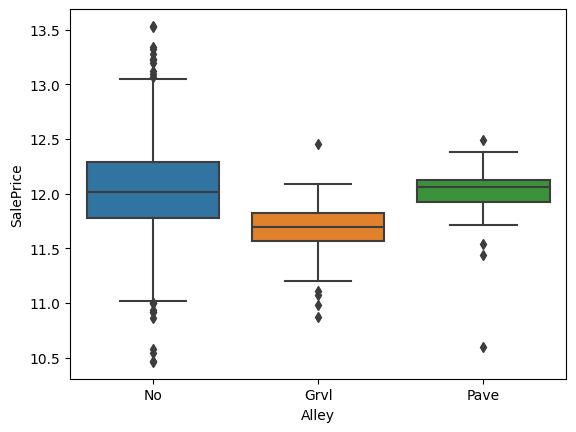

In [21]:
sns.boxplot(
    x = 'Alley',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 2.4 Fence variable

In [22]:
print(f"The Fence variable contains the type of fence around the house, where a missing value means that there is not any fence. {np.round(missing_vals['Fence']/df.shape[0]*100,4)}% of the values are missing. It is an unordered factor.")

The Fence variable contains the type of fence around the house, where a missing value means that there is not any fence. 80.4385% of the values are missing. It is an unordered factor.


<AxesSubplot: xlabel='Fence', ylabel='SalePrice'>

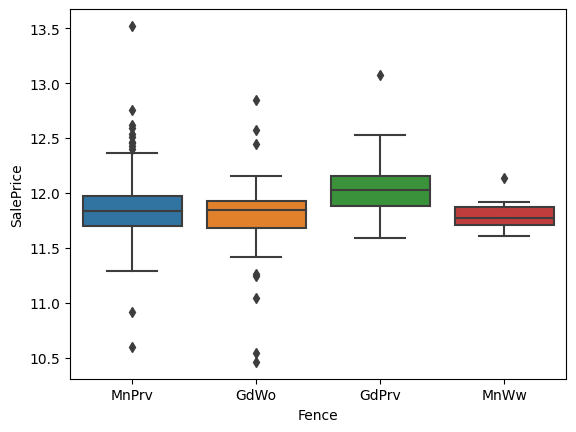

In [23]:
sns.boxplot(
    x = 'Fence',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

In [24]:
df['Fence'] = df['Fence'].fillna('No')

<AxesSubplot: xlabel='Fence', ylabel='SalePrice'>

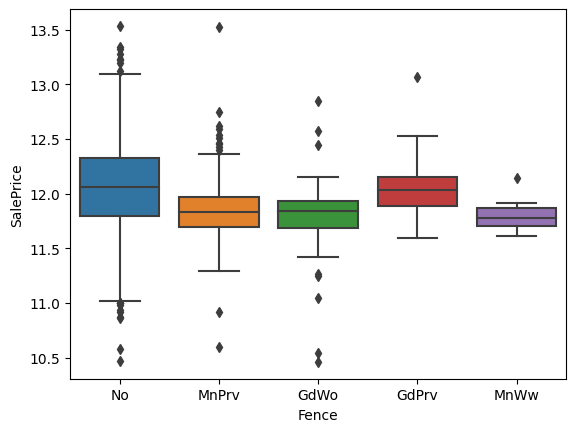

In [25]:
sns.boxplot(
    x = 'Fence',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 2.5 Fireplace
There are 2 variables relative to the fireplaces: Fireplaces, counting the number of fireplaces, and FireplaceQu for the fireplace quality.

In [26]:
print(f"The FireplaceQu variable has {np.round(missing_vals['FireplaceQu']/df.shape[0]*100,4)}% missing values. It is an ordered factor.")

The FireplaceQu variable has 48.6468% missing values. It is an ordered factor.


In [27]:
df[df['FireplaceQu'].isna()]['Fireplaces'].value_counts()

0    1420
Name: Fireplaces, dtype: int64

<AxesSubplot: xlabel='FireplaceQu', ylabel='SalePrice'>

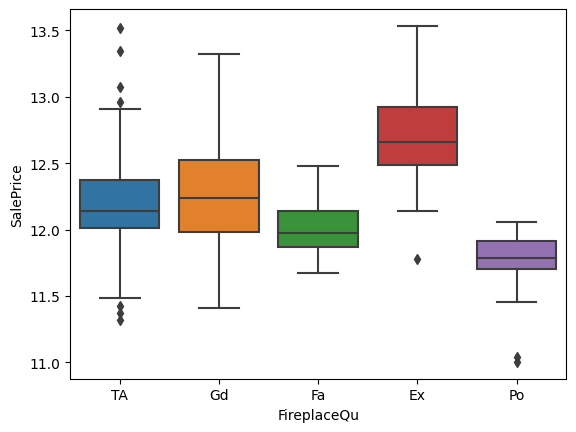

In [28]:
sns.boxplot(
    x = 'FireplaceQu',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We replace the missing values by "No"

In [29]:
df['FireplaceQu'] = df['FireplaceQu'].fillna('No')

<AxesSubplot: xlabel='FireplaceQu', ylabel='SalePrice'>

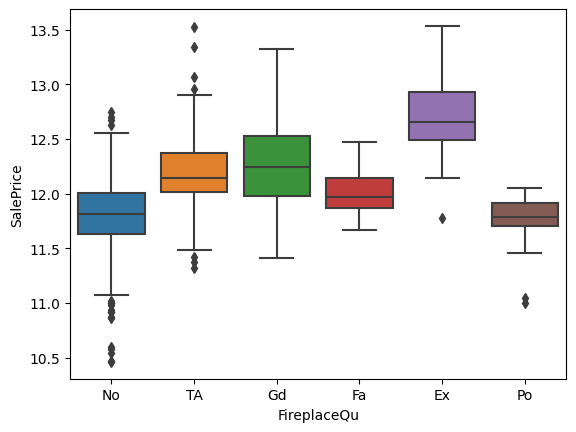

In [30]:
sns.boxplot(
    x = 'FireplaceQu',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 2.6 LotFrontage variable

In [31]:
print(f"The LotFrontage variable contains the linear feet of street connected to property. It is a numerical variable, with {np.round(missing_vals['LotFrontage']/df.shape[0]*100,4)}% missing values.")


The LotFrontage variable contains the linear feet of street connected to property. It is a numerical variable, with 16.6495% missing values.


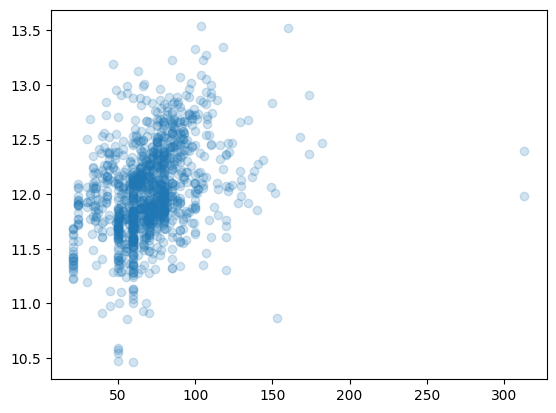

In [35]:
plt.scatter(x = 'LotFrontage',y = 'SalePrice',data = df, alpha = 0.2)

We will fill this variable with a KNN model

### 2.7 Garage variables
There are 7 variables related to houses' garages.

GarageCars and GarageArea have 1 missing value for the observation Id 2577. This house seems to not have any garage, thus we replace the values of these 2 predictors by 0 and remove the value in GarageType.


In [36]:
df.iloc[2576,:]

Id                 2577
MSSubClass           70
MSZoning             RM
LotFrontage        50.0
LotArea            9060
                  ...  
YrSold             2007
SaleType             WD
SaleCondition    Alloca
SalePrice           NaN
overall_fac          TA
Name: 2576, Length: 82, dtype: object

In [37]:
df['GarageType'] = np.where(
    df['GarageArea'].isna(),
    np.nan,
    df['GarageType']
)
df['GarageArea'] = df['GarageArea'].fillna(0)
df['GarageCars'] = df['GarageCars'].fillna(0)


In the rows when there is no garage, GarageCars and GarageArea are fixed to 0 and GarageType, GarageYrBlt, GarageFinish, GarageQual and GarageCond are missing. All 5 are ordered factors.

There is a row with Id 2127 where GarageYrBlt, GarageFinish, GarageQual and GarageCond are missing, but GarageArea > 0 and GarageType exists. 

Except for this row, the predictors GarageType, GarageFinish, GarageQual and GarageCond will be filled with a new value "No" and GarageYrBlt will be filled by the year the house was built.

We will fill the row 2127 with a knn method.


In [38]:
df['GarageYrBlt'] = np.where(
    df['GarageYrBlt'].isna() & df['Id'] != 2127,
    df['YearBuilt'],
    df['GarageYrBlt']
)
df['GarageType'] = df['GarageType'].fillna('No')
df['GarageFinish'] = df['GarageFinish'].fillna('No')
df['GarageQual'] = df['GarageQual'].fillna('No')
df['GarageCond'] = df['GarageCond'].fillna('No')

df[df['Id']==2127][['GarageYrBlt','GarageType','GarageFinish','GarageQual','GarageCond']] = np.nan

C:\Users\Julie\AppData\Local\Temp\ipykernel_13328\2744137296.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['Id']==2127][['GarageYrBlt','GarageType','GarageFinish','GarageQual','GarageCond']] = np.nan


### 2.8 Basement variables
There are 11 variables related to houses' basements, and all of them have missing values with different percentages:


In [39]:
for col in [col for col in df.columns if col.startswith('Bsmt')]:
    print(f"- There are {np.round(missing_vals[col]/df.shape[0]*100,4)}% missing values for variable {col}")

- There are 2.7749% missing values for variable BsmtQual
- There are 2.8092% missing values for variable BsmtCond
- There are 2.8092% missing values for variable BsmtExposure
- There are 2.7064% missing values for variable BsmtFinType1
- There are 0.0343% missing values for variable BsmtFinSF1
- There are 2.7407% missing values for variable BsmtFinType2
- There are 0.0343% missing values for variable BsmtFinSF2
- There are 0.0343% missing values for variable BsmtUnfSF
- There are 0.0685% missing values for variable BsmtFullBath
- There are 0.0685% missing values for variable BsmtHalfBath


All of these predictors are either ordered factors or numerical.

The row with Id 2121 is NA for all basement variables. We replace the numerical values by 0 and the factor ones by "No".

The row with Id 2189 is the other one with NA for the variables related to Bathrooms in the basement. We replace them with 0.

The rows with Id 2041, 2186 and 2525 contain missing values only for BsmtCond. We replace them with the values in BsmtQual, which are average.

The rows with Id 949, 1488 and 2349 contain missing values only for BsmtExposure. Since for these profiles the BsmtQual and BsmtCond are average, we replace them with the "Av" value.


All other rows, we consider that there is no basement. We replace the missing value by "No" except for BsmtExposure where we will replace it with "None" since the value "No" already exists.


In [40]:
for col in ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']:
    df[col] = df[col].fillna(0)

df['BsmtCond'] = np.where(
    (df['BsmtCond'].isna()) & (~ df['BsmtQual'].isna()),
    df['BsmtQual'],
    df['BsmtCond']
)
df['BsmtQual'] = df['BsmtQual'].fillna('No')
df['BsmtCond'] = df['BsmtCond'].fillna('No')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('No')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('No')
df['BsmtExposure'] = np.select(
    [
        (df['BsmtExposure'].isna()) & (df['BsmtQual'] != 'No'),
        df['BsmtQual'] == 'No'
    ],
    [
        'Av','None'
    ],
    df['BsmtExposure']
)

# Stopped at line 431 or the EDA.Rmd file.

### 2.9 Masonry veneer variables

In [41]:
print(f"There are 2 variables related to Masonry veneer: MasVnrArea and MasVnrType. The first has {missing_vals['MasVnrArea']} missing values, and the latter {missing_vals['MasVnrType']}.")

There are 2 variables related to Masonry veneer: MasVnrArea and MasVnrType. The first has 23 missing values, and the latter 24.


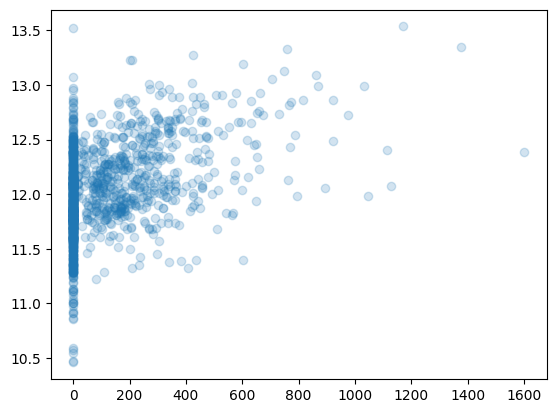

In [43]:
plt.scatter(x = 'MasVnrArea',y = 'SalePrice',data = df, alpha =0.2)

<AxesSubplot: xlabel='MasVnrType', ylabel='SalePrice'>

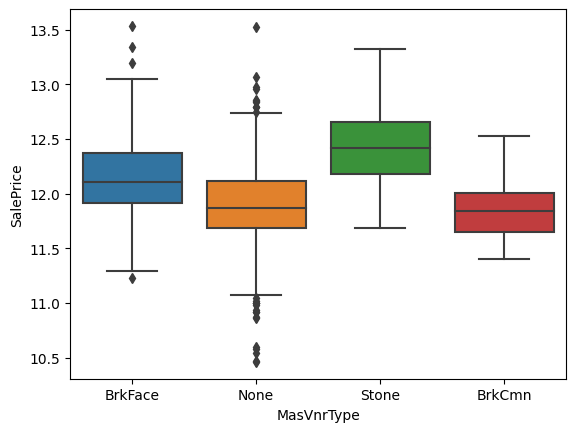

In [44]:
sns.boxplot(
    x = 'MasVnrType',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

Row Id 2611 has a missing value for MasVnrType but not MasVnrArea. We will fill MasVnrArea with 0 and  MasVnrType with "None" for all missing values except Id 2611, and use a knn impute for this specific row.


In [45]:
df['MasVnrType'] = np.where(
    df['MasVnrArea'].isna(),
    "None",
    df['MasVnrType']
)
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

### 2.10 Other variables
MSZoning has 4 missing values, Utilities 2, Functional 2, Exterior1st, Exterior2nd, Electrical, KitchenQual and SaleType have 1. All of these are factors, some ordered some not.

We fill these variables with a knn impute.

In [46]:

numerical_cols  = list(df.select_dtypes('number'))
categorical_cols = [col for col in df.columns if col not in numerical_cols]

imputer = KNNImputer(n_neighbors=2)
imputed_numerical = imputer.fit_transform(df[numerical_cols])
imputed_numerical = pd.DataFrame(imputed_numerical)
imputed_numerical.columns = numerical_cols

df = pd.concat(
    [
        df[categorical_cols],
        imputed_numerical
    ],
    axis = 1)

df['PoolArea'] = np.where(
    df['PoolQC'] == 'No',
    0,
    df['PoolArea']
)

## Step 3 - Change variable types
Some of the columns received the wrong type when reading the files: either they are written as categorical but should be numerical (and ordered), or they are numerical but should have been categoricals.

Some of the columns that are numerical could be seen as factors instead.

MSSubClass identifies the type of dwelling involved in the sale. It is coded as a numerical variable but is really categorical.

<AxesSubplot: xlabel='MSSubClass', ylabel='SalePrice'>

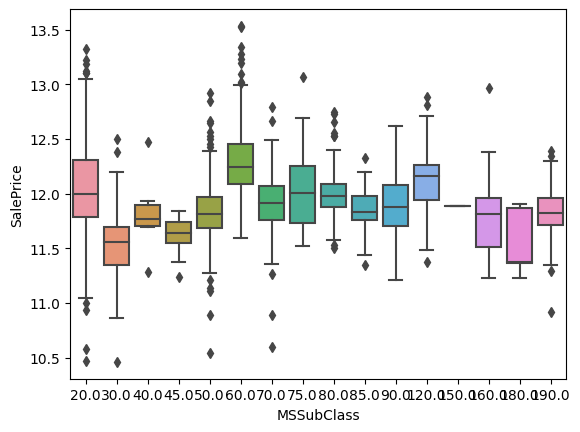

In [47]:
sns.boxplot(
    x = 'MSSubClass',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

MoSold and YrSold give details about the date when the house was sold.


<AxesSubplot: xlabel='MoSold', ylabel='SalePrice'>

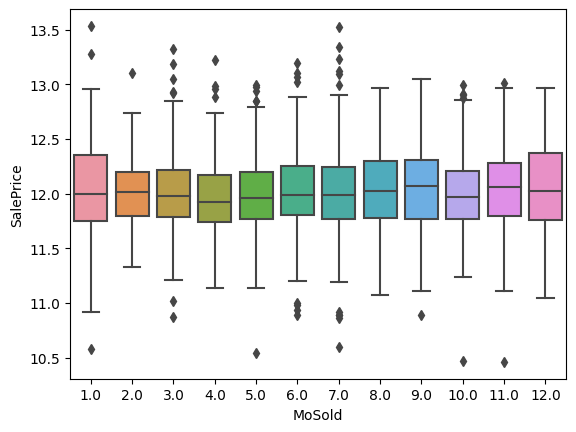

In [48]:
sns.boxplot(
    x = 'MoSold',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

<AxesSubplot: xlabel='YrSold', ylabel='SalePrice'>

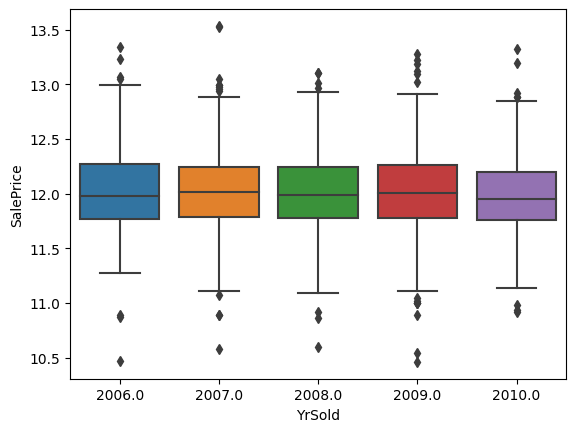

In [49]:

sns.boxplot(
    x = 'YrSold',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We correct these 3 variables to categoricals.


In [50]:
df['MSSubClass'] = pd.Categorical(df['MSSubClass'])
df['MoSold'] = pd.Categorical(df['MoSold'])
df['YrSold'] = pd.Categorical(df['YrSold'])

In [51]:
df.dtypes.value_counts()

object      44
float64     35
category     1
category     1
category     1
dtype: int64

In [52]:
# we finish by correcting all the objects columns to categoricals
for col in list(df.select_dtypes('object')):
    df[col] = pd.Categorical(df[col])

## Step 4 - Feature Engineering
Let's group some of the variables together to see if they have a better impact on the SalePrice

### 4.1 Total number of bathrooms
Multiple variables describe the number of bathrooms in the houses:

Let's group them together into a TotalBathrooms variable


In [53]:
df['TotalBathrooms'] = df['BsmtFullBath'] + df['FullBath'] + 0.5 * (df['BsmtHalfBath'] + df['HalfBath'])

<AxesSubplot: xlabel='TotalBathrooms', ylabel='SalePrice'>

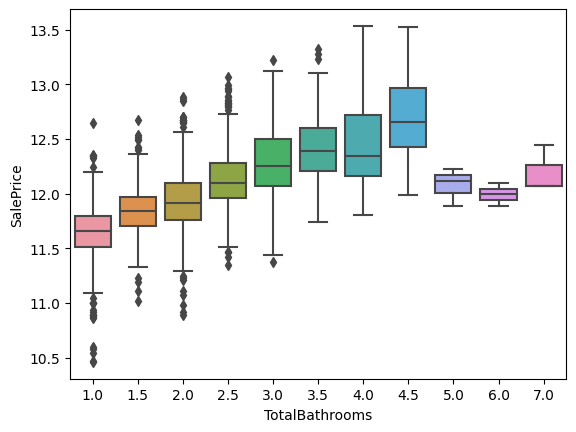

In [54]:
sns.boxplot(
    x = 'TotalBathrooms',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 4.2 House age, remodeled (Y/N) and IsNew
We put together the 3 variables concerning years: YearBuilt, YearRemodAdd and YrSold. Since the year of remodel is the same as the year built if there hasnt been any remodelling, we can separate the data if it has been remodeled or not. Same thing, we can calculate the age of the house when it was sold, and if it was "new", aka less than 2 years old.


In [55]:
df['Age'] = df['YrSold'].astype(int) - df['YearBuilt']
df['Remodeled'] = np.where(
    df['YearRemodAdd'] == df['YearBuilt'],
    "Y",
    "N"
)
df['New'] = np.where(df['Age'] < 2, "Y", "N")

### 4.3 Total Square feet

Let's group all the housing area and the porch area.

In [56]:
df['PorchArea'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] +  df['ScreenPorch'] 
df['TotalSquareFeet'] = df['GrLivArea'] + df['GarageArea'] + df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['LowQualFinSF'] 

## Step 5 - Outliers
We sawe earlier that 2 rows seem to have very high values for the total square feet while the sale price stays not very high. Let's check these rows:


In [57]:
df.iloc[ [523,1298], :]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,MiscVal,MoSold,YrSold,SalePrice,TotalBathrooms,Age,Remodeled,New,PorchArea,TotalSquareFeet
523,RL,Pave,No,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,...,0.0,10.0,2007.0,12.126759,4.5,0.0,N,Y,614.0,7820.0
1298,RL,Pave,No,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,...,0.0,1.0,2008.0,11.982929,4.5,0.0,Y,Y,506.0,12704.0


Both of them are new built, with good quality in general and high size. It is probably an error in the dataset.

We remove the two rows containing these profiles.

In [58]:
df = df[ ~ df['Id'].isin([524,1299])].copy()

## Step  6 - One Hot Encoding
For the categorical columns it is important to use one hot encoding as the XGBoost will not work as well else.

In [59]:
# features to encode as categorical
features_to_ohe = list(df.select_dtypes('object')) + list(df.select_dtypes('category'))
df[features_to_ohe] = df[features_to_ohe].apply(lambda x: x.astype("category"))

# set up the encoder
ohe = OneHotEncoder(sparse = False,
                    handle_unknown = 'error',
                    drop = 'first')
ohe = ohe.fit(df[features_to_ohe])

# output of encoder
index_name = str(df.index.name)
transformed = pd.DataFrame(ohe.transform(df[features_to_ohe]))
transformed.columns = ohe.get_feature_names_out(features_to_ohe)

# put things back together
df = pd.concat([df.reset_index(drop = True),
                            transformed.reset_index(drop = True)],
                            axis = 1)
# delete input columns
df.drop(features_to_ohe,
                    axis = 1,
                    inplace = True)

## Step 6 - Modelling

In [60]:
df.drop('Id', axis=1,inplace = True)

In [61]:
train = df[~df['SalePrice'].isna()].copy()
test = df[df['SalePrice'].isna()].copy()

# Let's separate the features from the target
X = train.drop(['SalePrice'], axis = 1, inplace = False)
y = train["SalePrice"]

features = X.columns

# Let's create a validation set to remove some ovefitting
X_train,X_validation,y_train,y_validation = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
    shuffle = True)

In [62]:
# init model
xgb = XGBRegressor()
# set up parameters possibilities
params={"eta":[0.05,0.1,0.2,0.3],
        "gamma":[0,0.01,0.1,0.15,0.2],
        "max_depth":[3,4,5,6,7]
       }
gbm_model = GridSearchCV(xgb,
                    params,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 1)
gbm_model.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.05, 0.1, 0.2, 0.3],
                         'gamma': [0, 0.01, 0.1, 0.15, 0.2],
                         'max_depth': [3, 4, 5, 6, 7]},
             verbose=1)

## Step 7 - Answer the questions
Let's answer the questions listed at the beginning of this notebook.

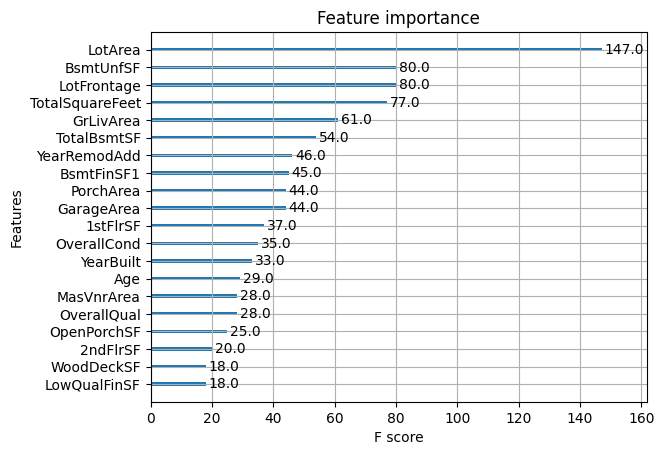

In [70]:
# XGB feature importance plot
plot_importance(gbm_model.best_estimator_, max_num_features = 20   )
X.columns;


In [76]:
# init the shap values
explainer = shap.TreeExplainer(gbm_model.best_estimator_)
shap_values = explainer.shap_values(DMatrix(X,label = y))

In [98]:
# order the feature importance
feature_importance = pd.DataFrame(
    list(zip(X.columns, gbm_model.best_estimator_.feature_importances_)),
    columns=["col_name", "feature_importance_vals"],
)
feature_importance.sort_values(
    by=["feature_importance_vals"], ascending=False, inplace=True
)

In [95]:
def check_shap_feature(feat):
    i = feature_importance[feature_importance['col_name']==feat].index[0]
    shap.summary_plot(shap_values[:,i:i+1], X.iloc[:, i:i+1])
    plt.title(feat)

### Question 1: Is having a basement having an impact on the price of a house?

In [105]:
feature_importance.head(20)

,col_name,feature_importance_vals
2,OverallQual,0.104391
4,YearBuilt,0.066437
279,MSSubClass_60.0,0.063521
10,TotalBsmtSF,0.063483
36,TotalSquareFeet,0.061072
22,Fireplaces,0.043971
14,GrLivArea,0.037033
224,GarageType_Attchd,0.027899
24,GarageCars,0.027796
42,MSZoning_RM,0.014126


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

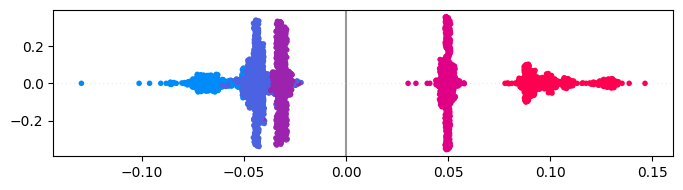

In [112]:
check_shap_feature(feat = 'OverallQual')

### Question 2: Are the new build cheaper than older houses?

In [107]:
[col for col in feature_importance['col_name'] if 'New' in col]

['SaleType_New', 'New_Y']

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

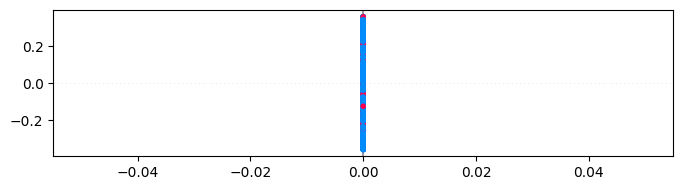

In [111]:
check_shap_feature(feat = 'New_Y')

### Question 3: What are the most important features for our model?